In [1]:
!pip install yfinance

# TimeSeries Forecasting of Google Data using RNN,LSTM & GRU



In [2]:
import yfinance as yf
import pandas as pd

# Download Google's stock price data
ticker = 'GOOG'
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')

# Display the first few rows of the dataset
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.615220,15.678981,15.547723,15.610239,15.592496,78541293
2010-01-05,15.620949,15.637387,15.480475,15.541497,15.523831,120638494
2010-01-06,15.588072,15.588072,15.102393,15.149715,15.132495,159744526
2010-01-07,15.178109,15.193053,14.760922,14.797037,14.780218,257533695
2010-01-08,14.744733,15.024933,14.672753,14.994298,14.977255,189680313


yf.download(): This function comes from the yfinance library and is used to download historical stock market data.

ticker: This variable contains the ticker symbol for the stock you're interested in. In this case, it's 'GOOG' for Google.

start='2010-01-01': This specifies the start date for the data. The data will include daily stock prices from January 1, 2010.

end='2023-01-01': This specifies the end date for the data. The data will include daily stock prices up to December 31, 2022.

In [3]:
# Check for missing values
missing_values = data.isnull().sum()

# Fill missing values using forward fill method
data.fillna(method='ffill', inplace=True)

# Verify that missing values are handled
data.isnull().sum()

<ipython-input-3-35e28281c88c>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


The resulting data object is a Pandas DataFrame that includes columns like Date, Open, High, Low, Close, Adj Close, and Volume.

In [4]:
# Creating additional features
data['MA_10'] = data['Close'].rolling(window=10).mean()  # 10-day moving average
data['MA_50'] = data['Close'].rolling(window=50).mean()  # 50-day moving average
data['Returns'] = data['Close'].pct_change()  # Daily returns

# Drop the first row where returns are NaN
data.dropna(inplace=True)

data.head()

,Open,High,Low,Close,Adj Close,Volume,MA_10,MA_50,Returns
Date,,,,,,,,,
2010-03-16,13.993300,14.157434,13.966650,14.077235,14.061234,137774484,14.077982,13.889160,0.003587
2010-03-17,14.154446,14.232902,14.053574,14.086201,14.070189,133362007,14.128393,13.858679,0.000637
2010-03-18,14.065280,14.157933,14.021444,14.107123,14.091088,71354455,14.157808,13.829992,0.001485
2010-03-19,13.947721,14.146974,13.879974,13.947721,13.931867,192486794,14.147322,13.805952,-0.011299
2010-03-22,13.850834,14.118331,13.805255,13.885454,13.869671,160792439,14.134919,13.787720,-0.004464


<ul>
<li>data['MA_10']: Calculates the 10-day moving average of the 'Close' price. The moving average smooths out short-term fluctuations and highlights longer-term trends.

data['Close'].rolling(window=10).mean() computes the rolling mean over a window of 10 days.</li>
<li>data['MA_50']: Calculates the 50-day moving average of the 'Close' price. This is useful for identifying longer-term trends and smoothing out price data.

data['Close'].rolling(window=50).mean() computes the rolling mean over a window of 50 days.</li>
<li>data['Returns']: Calculates the daily returns, which is the percentage change in the closing price from one day to the next.

data['Close'].pct_change() computes the percentage change between the current and prior element.</li>
    </ul>

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Select features to normalize
features = ['Close', 'MA_10', 'MA_50', 'Returns']

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the features
data[features] = scaler.fit_transform(data[features])

# Display the normalized data
data.head()


,Open,High,Low,Close,Adj Close,Volume,MA_10,MA_50,Returns
Date,,,,,,,,,
2010-03-16,13.993300,14.157434,13.966650,0.022998,14.061234,137774484,0.020294,0.015485,0.422030
2010-03-17,14.154446,14.232902,14.053574,0.023062,14.070189,133362007,0.020660,0.015258,0.411167
2010-03-18,14.065280,14.157933,14.021444,0.023212,14.091088,71354455,0.020874,0.015045,0.414291
2010-03-19,13.947721,14.146974,13.879974,0.022072,13.931867,192486794,0.020798,0.014866,0.367207
2010-03-22,13.850834,14.118331,13.805255,0.021626,13.869671,160792439,0.020708,0.014730,0.392380


In [6]:
import numpy as np

# Define the number of previous days to consider for each prediction
time_steps = 60

# Function to create sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 0])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

# Prepare the data for the RNN
X, y = create_sequences(data[['Close', 'MA_10', 'MA_50', 'Returns']].values, time_steps)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2530, 60, 4)
y_train shape: (2530,)
X_test shape: (633, 60, 4)
y_test shape: (633,)


<ul>
<li>
Function Purpose: Converts the data into sequences suitable for time series forecasting. Each sequence consists of time_steps number of days’ worth of data, and the target value (y) is the closing price of the next day.

Parameters:

data: The feature data from which sequences are created.
time_steps: The number of previous days used to predict the next day's value.
    </li></ul>

<ul><li>time_steps = 60: This means that the model will consider the past 60 days of stock prices to predict the next day's price. For example, if you want to predict the stock price on day 61, the model will use the stock prices from day 1 to day 60 as input.</li>
<li>Training Set: 80% of the data is used for training the model.
    Testing Set: 20% of the data is reserved for testing the model’s performance.</li></ul>

## Using RNN

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Build the RNN model
model = Sequential()

# Add an RNN layer with 50 units
model.add(SimpleRNN(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a Dense layer with one unit (the output layer)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

<ul>
<li>Model Initialization: The Sequential model is used to stack layers linearly.
RNN Layer: Processes sequences of data and learns temporal patterns. The number of units and input shape are defined.
Dense Layer: Provides the output of the model, which in this case is a single value representing the predicted stock price.
Compilation: The model is compiled with the Adam optimizer and Mean Squared Error loss function to prepare it for training.</li>
    </ul>

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0141 - val_loss: 0.0416
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1667e-04 - val_loss: 0.0349
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3706e-04 - val_loss: 0.0271
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9658e-05 - val_loss: 0.0223
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.1545e-05 - val_loss: 0.0200
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1545e-05 - val_loss: 0.0160
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.0247e-05 - val_loss: 0.0168
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.1948e-05 - val_loss: 0.0142
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9250e-05 - val_loss: 0.0141
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1118e-05 - val_loss: 0.0112
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4534e-05 - val_loss: 0.0094
Epoch 12/20
80/80 ━━━━━━━━━━━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


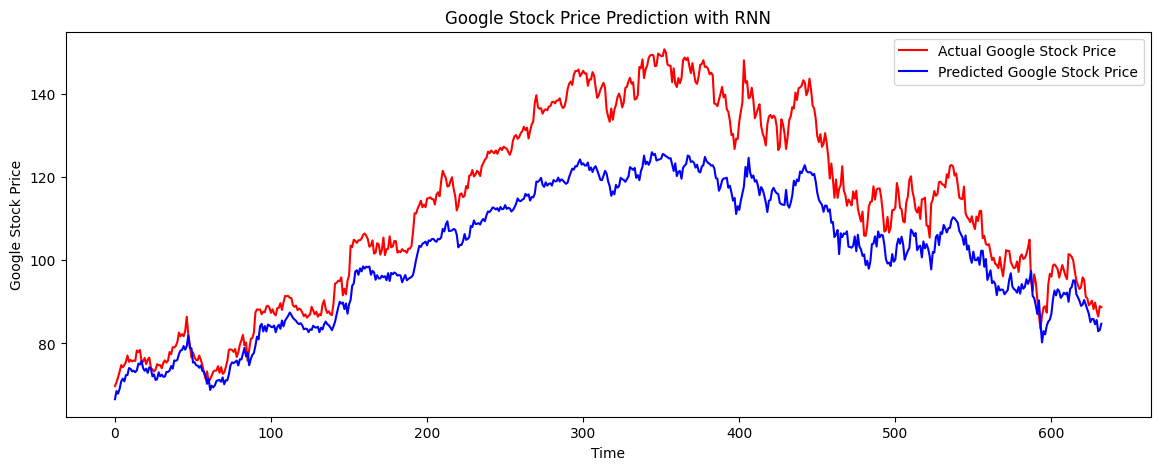

In [9]:
# Make predictions on the test set
predicted_stock_price = model.predict(X_test)

# Inverse transform to get actual stock prices
predicted_stock_price = scaler.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((predicted_stock_price.shape[0], 3))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))), axis=1))[:, 0]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test_actual, color='red', label='Actual Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction with RNN')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


The time values on the x-axis of your plot (e.g., 0, 100, 200) represent sequence indices rather than actual calendar dates.

Here’s a quick breakdown of what these indices typically represent:

Sequence Indices:
Time Step Indices: In time series forecasting, data is often organized into sequences or windows of a fixed length. Each number (0, 100, 200) represents the position of a data point or sequence in this organized structure.
Data Segmentation: For example, if you used sequences of 60 days, the x-axis values like 0, 100, 200 correspond to different segments or batches of 60 days each in your dataset.
How They Appear:
0: The start of the first sequence or time window.
100: An index representing a position in the dataset, often 100 time steps after the start.
200: Another index further into the dataset.
In summary, these values are indices that help you identify where each data point falls within the sequence of your test data rather than specific dates. If you want to convert these indices into actual dates, you would need to map them back to your original time series data.

current implementation only forecasts one step ahead (i.e., one day) for each time step in your test data.

model.predict(X_test) generates predictions for each time step in the X_test set.
Each prediction corresponds to the next immediate day after the last 60 days in X_test.

Each prediction corresponds to the next immediate day after the last 60 days in X_test.

X, y = create_sequences(data[['Close', 'MA_10', 'MA_50', 'Returns']].values, time_steps),You create sequences of 60 days (time_steps) for the model to learn from.
Each sequence (X[i]) has 60 days of data, and the target value (y[i]) is the price on the next day after the 60 days.

When you call model.predict(X_test), the model predicts the next day's price for each sequence in X_test.
Since X_test contains sequences of 60 days, the model outputs a single price prediction for the next day after each 60-day window.

For Each Sequence: The model predicts one price value for the next day following the end of the 60-day input sequence. Hence, each sequence in X_test predicts only one future value, which is the immediate next day’s price after the last day of the sequence.

The model.predict(X_test) operation forecasts only one step ahead for each test sequence. The results are for the next immediate day after each 60-day period in your test set. This behavior is due to the model being trained to predict the next day’s value directly after each 60-day window.

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_actual, predicted_stock_price)
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_stock_price))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 11.07882411587526
Root Mean Squared Error: 13.142710911990424


## LSTM

In [11]:
from tensorflow.keras.layers import LSTM

# Build the LSTM model
model_lstm = Sequential()

# Add an LSTM layer with 50 units
model_lstm.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a Dense layer with one unit (the output layer)
model_lstm.add(Dense(units=1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the LSTM model
model_lstm.summary()

# Train the LSTM model
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3810e-05 - val_loss: 0.0012
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5385e-05 - val_loss: 0.0024
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5846e-05 - val_loss: 0.0012
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4830e-05 - val_loss: 0.0021
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4496e-05 - val_loss: 0.0016
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5692e-05 - val_loss: 0.0018
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7999e-05 - val_loss: 0.0019
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8775e-05 - val_loss: 0.0021
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6557e-05 - val_loss: 0.0012
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.4284e-05 - val_loss: 0.0013
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━

## GRU

In [12]:
from tensorflow.keras.layers import GRU

# Build the GRU model
model_gru = Sequential()

# Add a GRU layer with 50 units
model_gru.add(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a Dense layer with one unit (the output layer)
model_gru.add(Dense(units=1))

# Compile the model
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the GRU model
model_gru.summary()

# Train the GRU model
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           8,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,451 (33.01 KB)

 Trainable params: 8,451 (33.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - val_loss: 8.2582e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0633e-05 - val_loss: 8.6660e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8634e-05 - val_loss: 8.9670e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2403e-05 - val_loss: 8.4123e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7005e-05 - val_loss: 8.5685e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0648e-05 - val_loss: 0.0014
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0195e-05 - val_loss: 7.9372e-04
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2029e-05 - val_loss: 9.6591e-04
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3229e-05 - val_loss: 6.6844e-04
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2902e-05 - val_loss: 0.0017
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9472e-05 - val_loss: 0.0011
Ep

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


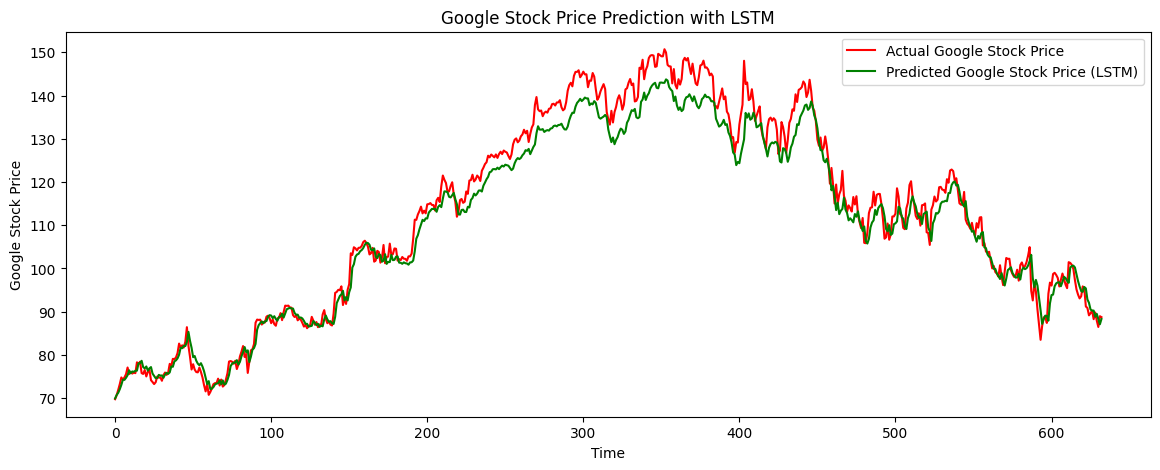

In [13]:
# Predicting the stock prices using the LSTM model
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Inverse transform to get actual stock prices
predicted_stock_price_lstm = scaler.inverse_transform(np.concatenate((predicted_stock_price_lstm, np.zeros((predicted_stock_price_lstm.shape[0], 3))), axis=1))[:, 0]

# Visualizing the LSTM results
plt.figure(figsize=(14,5))
plt.plot(y_test_actual, color='red', label='Actual Google Stock Price')
plt.plot(predicted_stock_price_lstm, color='green', label='Predicted Google Stock Price (LSTM)')
plt.title('Google Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


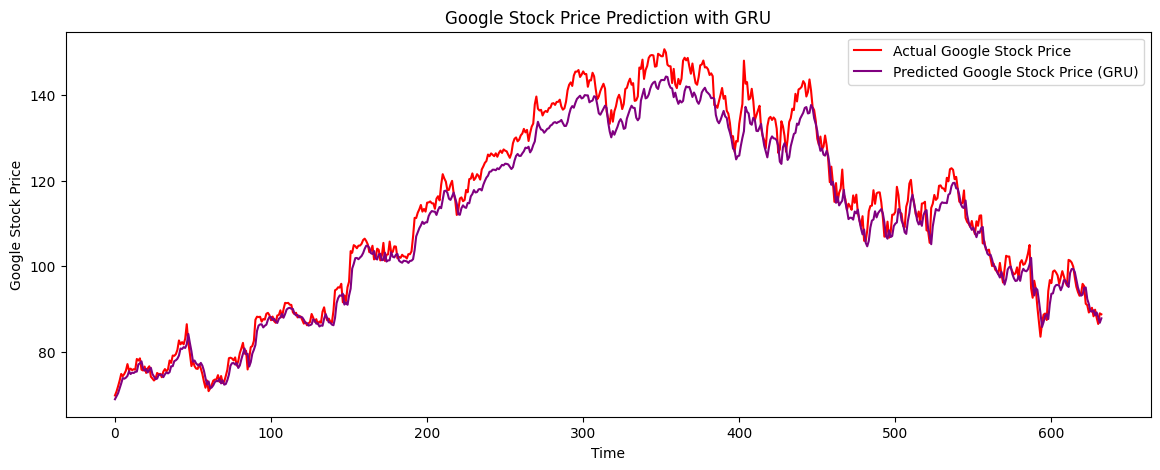

In [14]:
# Predicting the stock prices using the GRU model
predicted_stock_price_gru = model_gru.predict(X_test)

# Inverse transform to get actual stock prices
predicted_stock_price_gru = scaler.inverse_transform(np.concatenate((predicted_stock_price_gru, np.zeros((predicted_stock_price_gru.shape[0], 3))), axis=1))[:, 0]

# Visualizing the GRU results
plt.figure(figsize=(14,5))
plt.plot(y_test_actual, color='red', label='Actual Google Stock Price')
plt.plot(predicted_stock_price_gru, color='purple', label='Predicted Google Stock Price (GRU)')
plt.title('Google Stock Price Prediction with GRU')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


In [15]:
# LSTM Performance
mae_lstm = mean_absolute_error(y_test_actual, predicted_stock_price_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, predicted_stock_price_lstm))

print(f'LSTM - Mean Absolute Error: {mae_lstm}')
print(f'LSTM - Root Mean Squared Error: {rmse_lstm}')

# GRU Performance
mae_gru = mean_absolute_error(y_test_actual, predicted_stock_price_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test_actual, predicted_stock_price_gru))

print(f'GRU - Mean Absolute Error: {mae_gru}')
print(f'GRU - Root Mean Squared Error: {rmse_gru}')


LSTM - Mean Absolute Error: 3.118583717001501
LSTM - Root Mean Squared Error: 4.032944017953239
GRU - Mean Absolute Error: 3.07796596770615
GRU - Root Mean Squared Error: 3.84416308442448


In [16]:
# RNN predictions
predicted_stock_price_rnn = model.predict(X_test)

# Inverse transform to get actual stock prices
predicted_stock_price_rnn = scaler.inverse_transform(np.concatenate((predicted_stock_price_rnn, np.zeros((predicted_stock_price_rnn.shape[0], 3))), axis=1))[:, 0]


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [17]:
# RNN Performance
mae_rnn = mean_absolute_error(y_test_actual, predicted_stock_price_rnn)
rmse_rnn = np.sqrt(mean_squared_error(y_test_actual, predicted_stock_price_rnn))

# LSTM Performance
mae_lstm = mean_absolute_error(y_test_actual, predicted_stock_price_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, predicted_stock_price_lstm))

# GRU Performance
mae_gru = mean_absolute_error(y_test_actual, predicted_stock_price_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test_actual, predicted_stock_price_gru))

print(f'RNN  - Mean Absolute Error: {mae_rnn}, Root Mean Squared Error: {rmse_rnn}')
print(f'LSTM - Mean Absolute Error: {mae_lstm}, Root Mean Squared Error: {rmse_lstm}')
print(f'GRU  - Mean Absolute Error: {mae_gru}, Root Mean Squared Error: {rmse_gru}')


RNN  - Mean Absolute Error: 11.07882411587526, Root Mean Squared Error: 13.142710911990424
LSTM - Mean Absolute Error: 3.118583717001501, Root Mean Squared Error: 4.032944017953239
GRU  - Mean Absolute Error: 3.07796596770615, Root Mean Squared Error: 3.84416308442448


### Comparing RNN,LSTM & GRU

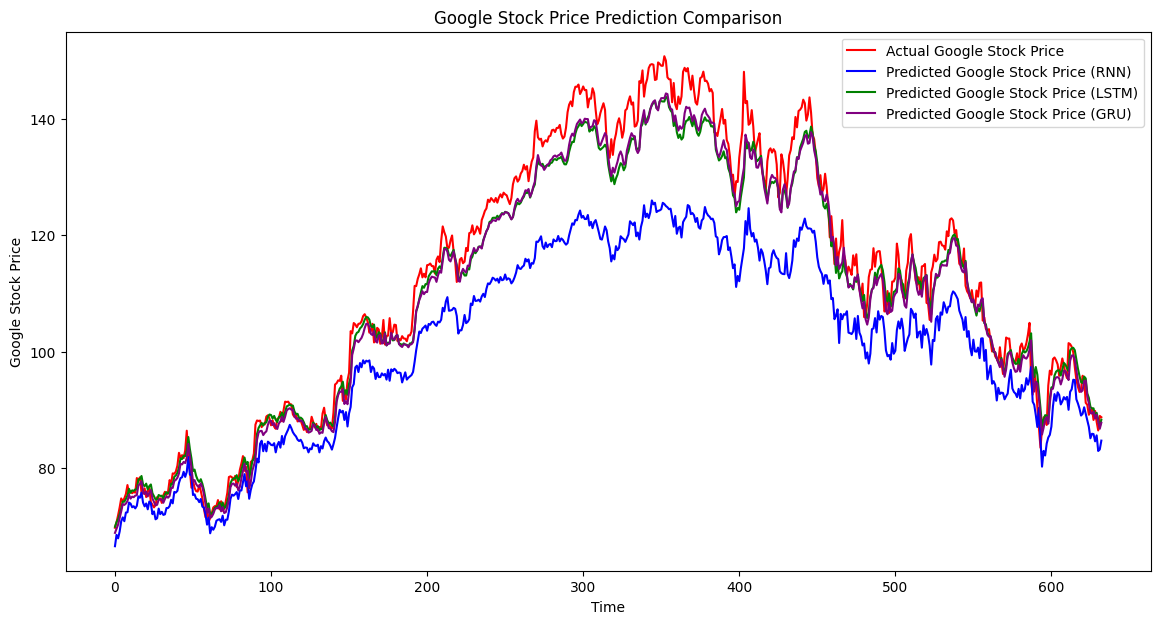

In [18]:
# Visualization of all models
plt.figure(figsize=(14,7))

plt.plot(y_test_actual, color='red', label='Actual Google Stock Price')
plt.plot(predicted_stock_price_rnn, color='blue', label='Predicted Google Stock Price (RNN)')
plt.plot(predicted_stock_price_lstm, color='green', label='Predicted Google Stock Price (LSTM)')
plt.plot(predicted_stock_price_gru, color='purple', label='Predicted Google Stock Price (GRU)')

plt.title('Google Stock Price Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


In [19]:
# Performance comparison summary
performance_summary = {
    'Model': ['RNN', 'LSTM', 'GRU'],
    'MAE': [mae_rnn, mae_lstm, mae_gru],
    'RMSE': [rmse_rnn, rmse_lstm, rmse_gru]
}

performance_df = pd.DataFrame(performance_summary)
print(performance_df)


  Model        MAE       RMSE
0   RNN  11.078824  13.142711
1  LSTM   3.118584   4.032944
2   GRU   3.077966   3.844163


## Extracting the date to make it more easy to understand

In [20]:
import yfinance as yf
import pandas as pd

# Download historical data
ticker = 'GOOGL'
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')

# Ensure the Date is the index
data.index = pd.to_datetime(data.index)


[*********************100%%**********************]  1 of 1 completed


In [21]:
from sklearn.preprocessing import MinMaxScaler

# Feature engineering: using 'Close' price for simplicity
data['Close'] = data['Close'].astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Define a function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Set sequence length and split data
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam

# Define models
def build_model(model_type='LSTM'):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])) if model_type == 'LSTM' else
              GRU(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])) if model_type == 'GRU' else
              SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Train models
models = {'RNN': build_model('RNN'), 'LSTM': build_model('LSTM'), 'GRU': build_model('GRU')}
for name, model in models.items():
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Make predictions
def predict_model(model, X_test):
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions)

predicted_stock_price_rnn = predict_model(models['RNN'], X_test)
predicted_stock_price_lstm = predict_model(models['LSTM'], X_test)
predicted_stock_price_gru = predict_model(models['GRU'], X_test)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0225
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5849e-05
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0892e-05
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8653e-05
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6687e-05
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6472e-05
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1058e-05
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5339e-05
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8039e-05
Epoch 10/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1338e-05
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0149
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4843e-05
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1939e-05
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.5768e-05
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

In [23]:
# Extract dates for the test set
dates_test = data.index[-len(y_test):]


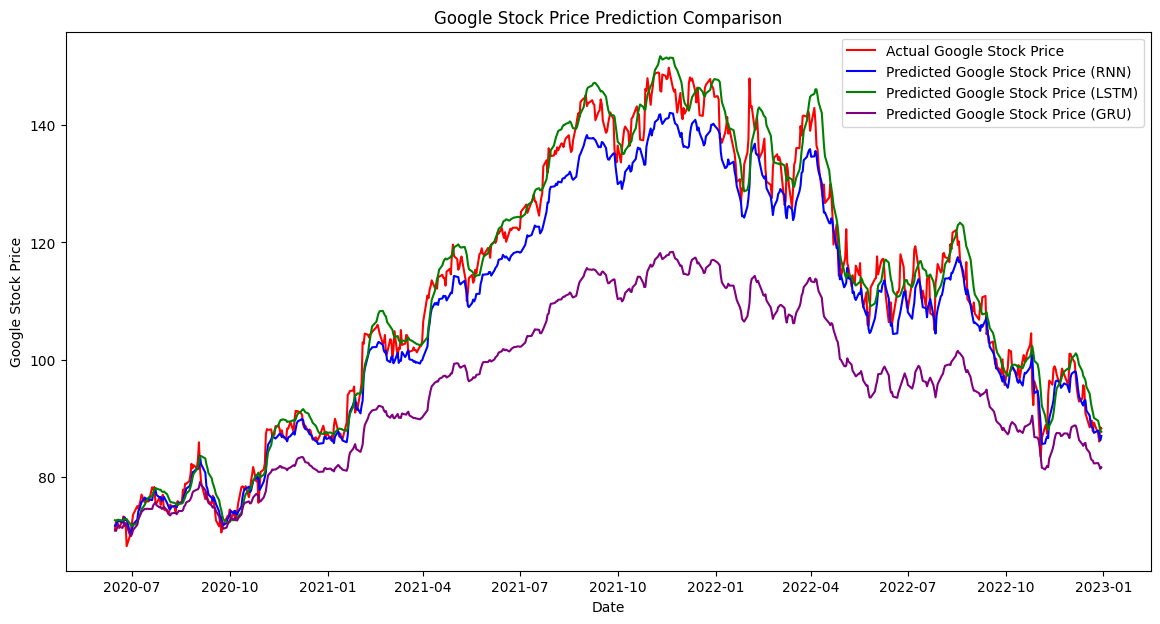

In [24]:
import matplotlib.pyplot as plt

# Convert scaled y_test to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting
plt.figure(figsize=(14,7))
plt.plot(dates_test, y_test_actual, color='red', label='Actual Google Stock Price')
plt.plot(dates_test, predicted_stock_price_rnn, color='blue', label='Predicted Google Stock Price (RNN)')
plt.plot(dates_test, predicted_stock_price_lstm, color='green', label='Predicted Google Stock Price (LSTM)')
plt.plot(dates_test, predicted_stock_price_gru, color='purple', label='Predicted Google Stock Price (GRU)')

plt.title('Google Stock Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


<ul>
<li>current implementation only forecasts one step ahead (i.e., one day) for each time step in your test data.</li>
<li>he model predicts one price value for the next day following the end of the 60-day input sequence. Hence, each sequence in X_test predicts only one future value, which is the immediate next day’s price after the last day of the sequence.</li>
<li>The model.predict(X_test) operation forecasts only one step ahead for each test sequence. The results are for the next immediate day after each 60-day period in your test set. This behavior is due to the model being trained to predict the next day’s value directly after each 60-day window.</li>
</ul>